In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries

#these libraries will be used to generate indicators from the raw data
import ta.momentum as moment
import ta.volume as vol
import ta.volatility as vl
import ta.trend as trend

#packages for viewing TearsheetStatistics
from qstrader.statistics.tearsheet import TearsheetStatistics

#import 
#for backtesting
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import datetime
import os.path
import sys

#import the different models that we will be using for selecting best performing models
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error #take root of this


#models
from xgboost import XGBRegressor as xgboost
from sklearn.linear_model import LinearRegression
from sklearn import svm

#note that for backtrader data feed must all be Yahoo Finance feed, otherwise custom data feed must be cretated

#Gridsearch will best time to do the train test split on
#Surivorship bias it not an issue because we only care about predicting the price of existing stocks, not stocks that do not exist anymore

#want to see all columns
pd.set_option('display.max_columns', None)


In [9]:
#configurations
api_key = 'F608FLWB0HW9X4N8'
output_format = "pandas"

output_size= "full"
window_size = 20 #20 years
training_device = "cuda"

We are considering the entire universe of US stocks, but we would like to filter for good quality stocks based on domain knowledge
1. Filter for stocks above a certain marketcap (which alphavantage provides)
2. Filter for stocks that have a certain average volatility measure (will pick the measure and the minimum)

Other possibilities:
1. Only pick stocks that are in a given index (so as to limit the Universt of stocks considered at one time)



In [79]:
nyse_stocks_list = []
nasdaq_stocks_list = []

with open("nyse_stocks_list.txt", 'r') as nyse_file, open("nasdaq_stock_list.txt", 'r') as nasdaq_file:
    nyse_stocks_list = nyse_file.read().split("\n")
    nasdaq_stocks_list = nasdaq_file.read().split("\n")

#go through all tickers. If tickers have a caret (^) then they are indices, not securities, meaning we cannot directly invest in it

temp_nyse_stocks_list = []
temp_nasdaq_stocks_list = []

for ticker in nyse_stocks_list:
    if '^' not in ticker:
        temp_nyse_stocks_list.append(ticker)
for ticker in nasdaq_stocks_list:
    if '^' not in ticker:
        temp_nyse_stocks_list.append(ticker)       
nyse_stocks_list = temp_nyse_stocks_list
nasdaq_stocks_list = temp_nasdaq_stocks_list

<h2>Pull Data</h2>

Note that this code is to get the full list of stocks in the NYSE exchange and the NASDAQ exchange. To pull all of these stocks simultaneously, combine them and send a call to the api

In [83]:
'''
Get data for a single stock from AlphaVantage
'''
def get_stock_timeseries(symbol="IBM"):
    timeseries_object = TimeSeries(key=api_key, output_format = "pandas")
    data, meta_data = timeseries_object.get_daily(symbol=symbol, outputsize=output_size)
    #reverse dataframe because it is going from most recent date to oldest date
    data_reverse = data.iloc[::-1].reindex(index=data.index[::-1])
    data = data_reverse
    data.rename(mapper={"1. open": "Open", "2. high": "High", "3. low": "Low", "4. close": "Close", "5. volume": "Volume"}, axis=1, inplace=True)
    #how many years of data do we have
    num_years = data.index[-1].year - data.index[0].year
    #num_years = data.index
    return data, meta_data, num_years

    
data, meta_data, num_years = get_stock_timeseries("AAPL")
data.head()

SyntaxError: EOL while scanning string literal (<ipython-input-83-ef65115bf1f3>, line 16)

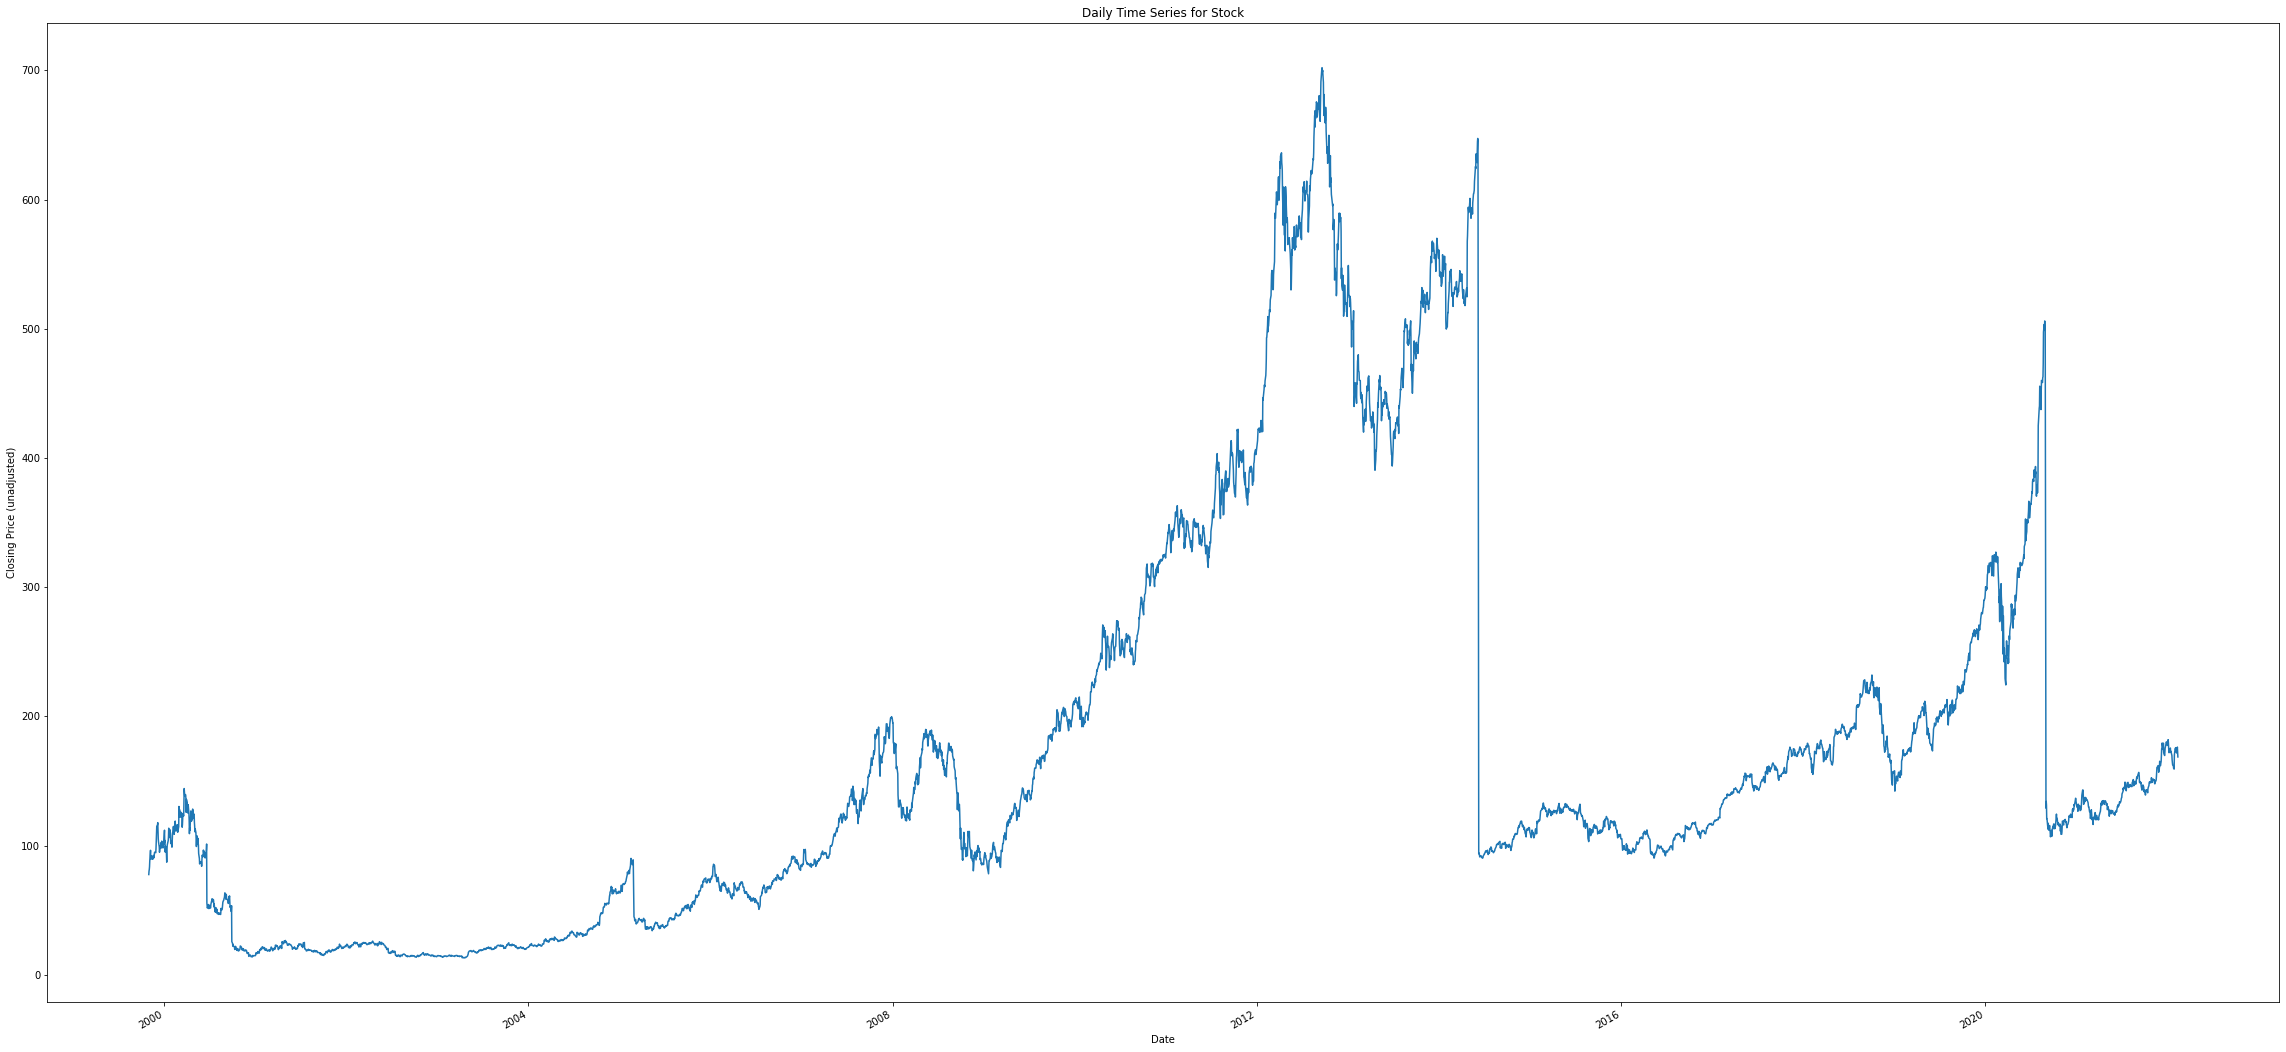

In [81]:
#Example of Data
plt.figure(figsize=(40,20))
data['Close'].plot()
plt.title('Daily Time Series for Stock')
plt.ylabel("Closing Price (unadjusted)")
plt.xlabel("Date")
plt.show()

In [ ]:
#lets make a datase

We will create a dictionary that will contain all stocks listed on the NYSE and NASDAQ stock exchange. 
Each (key value) pair will represent ("Stock Ticker Symbol", Pandas DataFrame containing daily data)

In [82]:
####AlphaVantage has annoying query limit######, 
'''
master_data = {}
#adding all nyse exchange stocks to master_data
for ticker in nyse_stocks_list:
    print(f'current ticker is {ticker}')
    new_ticker_data = get_stock_timeseries(ticker)
    master_data[ticker] = new_ticker_data
for ticker in nasdaq_stocks_list:
    new_ticker_data = get_stock_timeseries(ticker)
    master_data[ticker] = new_ticker_data
'''

current ticker is A
current ticker is AA
current ticker is AAC
current ticker is AAIC
current ticker is AAIN


ValueError: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.

<h3>Pulling Data With Yfinance</h3>
AlphaVantage has a api request limit (really annoying, spent so much time :(  
With Yahoo finance, I think its storing a multi level dataframe.
To access 'IBM' data for example, do 'Yahoo_Financ

In [ ]:
master_data = {}
all_stocks = nyse_stocks_list + nasdaq_stocks_list

master_data = yf.download(
    tickers=all_stocks,
    period="10y",
    interval="1d",
    group_by="ticker",
    threads=True)

[************          24%                       ]  1877 of 7725 completed

<h2>Data Exploration</h2>

<h2>Data Normalization</h2>

<h2>Training, Validation and Test Set Cretion</h2>

In [64]:
new_dict = {"AAPL": data}

In [66]:
new_dict["AAPL"].head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0
